In [401]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import pandas_profiling as pp
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans


In [388]:
df = pd.read_csv('bank/bank-full.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [30]:
#pp.ProfileReport(df)

In [31]:
df.campaign.describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [32]:
df.pdays.describe()

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

In [33]:
df.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

## Questões

### Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?

In [102]:
pd.concat([df.job.value_counts(), df.job.value_counts()/df.shape[0]], axis=1)

,job,job
blue-collar,9732,0.215257
management,9458,0.209197
technician,7597,0.168034
admin.,5171,0.114375
services,4154,0.091880
retired,2264,0.050076
self-employed,1579,0.034925
entrepreneur,1487,0.032890
unemployed,1303,0.028820
housemaid,1240,0.027427


In [99]:
count_housing_loan = df[(df.housing == 'yes') | (df.loan=='yes')]['job'].value_counts()
count_housing_loan.head()

blue-collar    7599
management     5225
technician     4608
admin.         3569
services       3063
Name: job, dtype: int64

In [100]:
pd.concat([count_housing_loan, count_housing_loan/count_housing_loan.sum()], axis=1).head()

,job,job
blue-collar,7599,0.271325
management,5225,0.186561
technician,4608,0.164530
admin.,3569,0.127432
services,3063,0.109366


Uma verificação nas variáveis __housing__ e __loan__, as que indicam a aquisição de empréstimo ou não, indicam que a profissão que mais adquire empréstimo é a classe __blue_collar__ (27%). Em seguida aparecem __gerentes__ (18%) e __técnicos__ (16%).

In [91]:
count_housing = df[df.housing=='yes']['job'].value_counts()
count_housing.head()

blue-collar    7048
management     4678
technician     4115
admin.         3182
services       2766
Name: job, dtype: int64

In [96]:
pd.concat([count_housing, count_housing/count_housing.sum()], axis=1).head()

,job,job
blue-collar,7048,0.280462
management,4678,0.186152
technician,4115,0.163749
admin.,3182,0.126622
services,2766,0.110068


In [92]:
count_loan = df[df.loan=='yes']['job'].value_counts()
count_loan.head()

blue-collar    1684
technician     1309
management     1253
admin.          991
services        836
Name: job, dtype: int64

In [97]:
pd.concat([count_loan, count_loan/count_loan.sum()], axis=1).head()

,job,job
blue-collar,1684,0.232468
technician,1309,0.180701
management,1253,0.172971
admin.,991,0.136803
services,836,0.115406


In [135]:
hausing = df[(df.housing=='yes') & (df.job=='blue-collar')].index
loan = df[(df.loan=='yes') & (df.job=='blue-collar')].index
hausing.size, loan.size, hausing.intersection(loan).size, hausing.union(loan).size 

(7048, 1684, 1133, 7599)

In [136]:
5915/7599,  1133/7599, 551/7599

(0.7783918936702198, 0.14909856560073695, 0.0725095407290433)

Analisando as duas variáveis separadamente na classe de trabalhadores __blue_collar__, fica evidente que a maioria dos empréstimos adquiridos são os relacionados à aquisição de habitações. Dos 7599 trabalhados da classe que possuem algum tipo de empréstimo, 78% e 7% são do tipo habitação e pessoal, respectivamente. Vale observar que 1133 (em torno de 15%) possuem empréstimos dos dois tipos. O diagrama abaixo ajuda na visualização desses números.

<IPython.core.display.Javascript object>


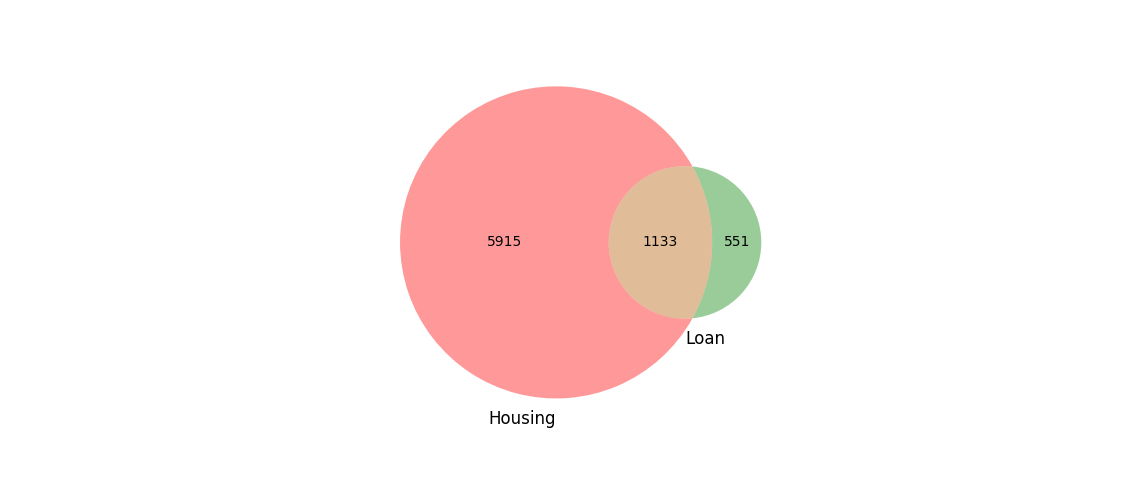

In [138]:
from matplotlib_venn import venn2
venn2([set(hausing), set(loan)], set_labels = ('Housing', 'Loan'), )
plt.show()

### Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados? 

In [319]:
count_campaign_sucesso = pd.DataFrame(df.groupby(by=['campaign', 'y'])['age'].count()).reset_index()
count_campaign_sucesso.columns = ['numero_ligacoes', 'sucesso', 'volume']
count_campaign_sucesso['sucesso_encoded'] = count_campaign_sucesso.sucesso.apply(lambda x: 1 if x == 'yes' else 0)
count_campaign_sucesso.head()

,numero_ligacoes,sucesso,volume,sucesso_encoded
0,1,no,14983,0
1,1,yes,2561,1
2,2,no,11104,0
3,2,yes,1401,1
4,3,no,4903,0


In [360]:
count_campaign_sucesso[(count_campaign_sucesso.numero_ligacoes>30) & (count_campaign_sucesso.sucesso == 'no')].shape[0]/ count_campaign_sucesso[(count_campaign_sucesso.numero_ligacoes>30)].shape[0],


(0.9473684210526315,)

<IPython.core.display.Javascript object>


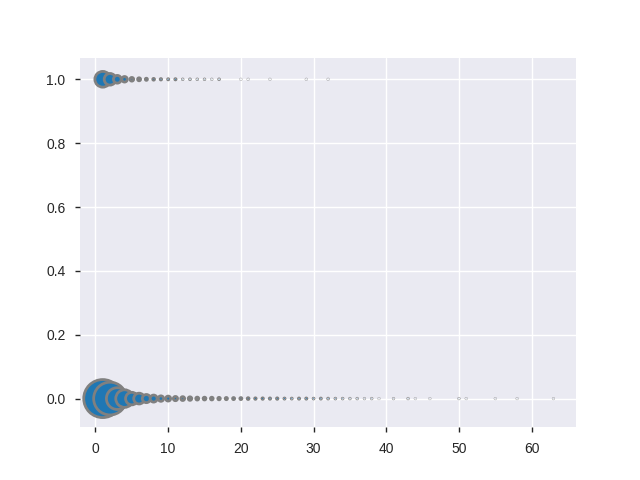

In [363]:
plt.scatter(count_campaign_sucesso.numero_ligacoes, count_campaign_sucesso.sucesso_encoded, s=count_campaign_sucesso.volume*0.05,  edgecolors="grey", linewidth=2)

O ponto mais relevante observado na associação do __número de contatos__ e o __sucesso da campanha__ é o fato de que o número de que aumentar o número de ligações não aumenta a aderência à campanha. Como pode ser visto no gráfico anterior, quando foram realizadas mais de 30 ligações, a maioria dos clientes não foram positivados (aproximadamente 95%). Pelo gráfico ainda é possível observar que a maioria dos clientes positivados o foram com menos que 4 ligações.

### Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão? 

In [159]:
pd.concat([df.y.value_counts(), df.y.value_counts()/df.shape[0]], axis=1)

,y,y
no,39922,0.883015
yes,5289,0.116985


In [195]:
df.campaign.describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [201]:
df[df.y =='yes']['campaign'].describe()

count    5289.000000
mean        2.141047
std         1.921826
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        32.000000
Name: campaign, dtype: float64

In [202]:
df[df.y =='no']['campaign'].describe()

count    39922.000000
mean         2.846350
std          3.212767
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [196]:
df.campaign.mean(), df.campaign.median(), df.campaign.mode()

(2.763840658246887, 2.0, 0    1
 dtype: int64)

In [214]:
df[df.y=='yes']['campaign'].mean(),df[df.y=='yes']['campaign'].median(), df[df.y=='yes']['campaign'].mode()

(2.1410474569861977, 2.0, 0    1
 dtype: int64)

In [215]:
df[df.y=='no']['campaign'].mean(),df[df.y=='no']['campaign'].median(), df[df.y=='no']['campaign'].mode()

(2.8463503832473322, 2.0, 0    1
 dtype: int64)

Duas das medidas de centralidade, média e mediana, sugerem 2 ligações na média para otimizar a adesão da campanha. No próximo gráfico, conseguimos observar que a distribuição das ligações não é exatamente normal, então para não correr o risco de escolher um que não reflete a realidade, descartamos a média aritmética, e usamos a mediana, que coincidentemente está muito próxima da média. Consiserando também os custos envolvidos, acredito que duas ligações por cliente, na média, é suficiente para se obter uma adesão próxima da ótima. No máximo, recomendaria 4 ligações por cliente (mediana + 1 desvio padrão no caso em que os clientes aderiram à campanha).

In [435]:
sns.distplot(df[df.y == 'yes']['campaign'] , color="b", label="yes", bins=2)

####  O resultado da campanha anterior tem relevância na campanha atual?

In [381]:
533+978+4283+618

6412

Usaremos um teste estatístico não paramético para duas variáveis pareadas. Para isso, consideraremos apenas os registros em que o valor da variável __poutcome__ fossem _failure_ ou _success_, já que são nesses casos que temos informações mais precisas. Assim, o teste foi aplicado em um total de __6412__ registros da base total.

A hipótese que estamos testando:

    h0: o resultado da campanha anterior não influência a campanha atual.

    h1: o resultado da campanha anterior influência a campanha atual.
    
    
O teste de McNemar para significância de mudanças é escolhido porque o estudo usa duas amostras relacionadas, do tipo “antes
e depois” e usa medidas categóricas. Para a aplicação do teste, é necessário uma tabela de quatro partes que descreva as mudanças dos resultados de ambas as campanhas. 

In [382]:
# Antes           Depois
#           _____________________  
#           failure      success  
# success   A=533       B=978
# failure   C=4283      D=618

Com a tabela anterior, calculamos o valor de _x2c_ (qui-quadrado), usando a equação _x2c_ = (|A-D|-1)**2 /(A+D)

In [379]:
d = {'antes': ['sucesso', 'insucesso'], 'depois_insucesso': [533, 4283],'depois_sucesso': [978,618] }
outcome = pd.DataFrame(data=d)
outcome

,antes,depois_insucesso,depois_sucesso
0,sucesso,533,978
1,insucesso,4283,618


In [383]:
x2c = (np.absolute(outcome.iloc[0,1] - outcome.iloc[1,2]) - 1)**2 /(outcome.iloc[0,1] + outcome.iloc[1,2])
x2c

6.1303214596003475

O _x2c_ calculado é 6.130, e é distribuído assintoticamente como um qui-quadrado com 1 grau de liberdade (gl=1). O valor crítico tabelado para o qui-quadrado com gl=1 e nível de significância 0.05 é 3.84 (https://www.ime.unicamp.br/~cnaber/Tabela%20da%20Qui-quadrado.pdf ). Como o valor observado (6.130) é maior que o valor crítico do qui_quadrado (3.84) rejeitamos a hipóstese nula, ou seja, o resultado da campanha anterior tem relevância para a campanha atual.

In [187]:
#df.groupby(by=[ 'campaign'])['y'].count()

### Qual o fator determinante para que o banco exija um seguro de crédito?

In [389]:
df.loan.value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

In [385]:
df.housing.value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [393]:
df['has_credit'] = df.apply(lambda x: 'yes' if (x['loan'] == 'yes') | (x['housing']=='yes') else  'no', axis=1)
df.has_credit.value_counts()

yes    28007
no     17204
Name: has_credit, dtype: int64

In [394]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,has_credit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,yes
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,yes
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,yes
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,yes
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,no


In [427]:
df2 = df[['age', 'job', 'marital', 'education', 'balance', 'has_credit']]
df2['has_credit_bin'] = df2.has_credit.apply(lambda x: 1 if x == 'yes' else 0)
df2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,job,marital,education,balance,has_credit,has_credit_bin
0,58,management,married,tertiary,2143,yes,1
1,44,technician,single,secondary,29,yes,1
2,33,entrepreneur,married,secondary,2,yes,1
3,47,blue-collar,married,unknown,1506,yes,1
4,33,unknown,single,unknown,1,no,0


<IPython.core.display.Javascript object>


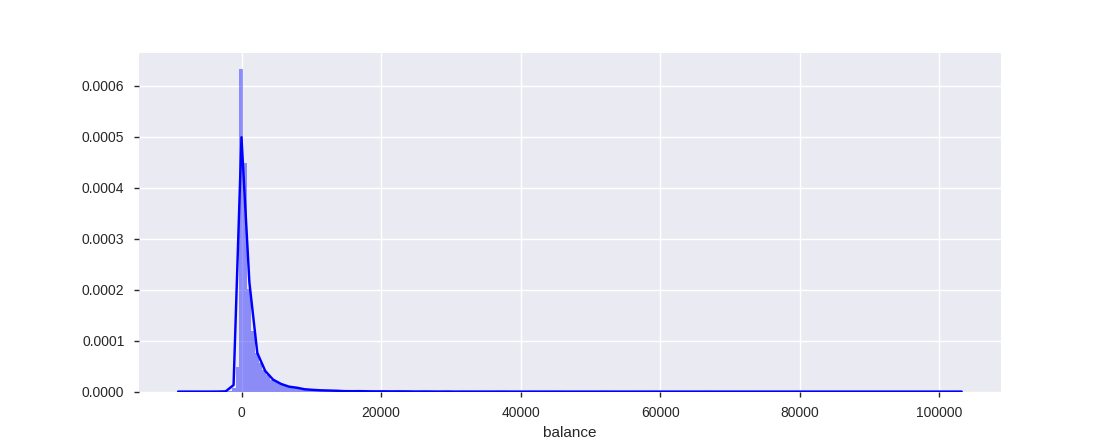

In [439]:
sns.distplot(df2.balance , color="b", label="yes", bins=200)

In [440]:
df2.balance.describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [464]:
from scipy.stats import iqr
irq = iqr(df2.balance)
irq

1356.0

In [442]:
mean = df2.balance.mean()
std = df2.balance.std()
mean, std

(1362.2720576850766, 3044.765829168518)

In [469]:
df3 = df2[ (df2.balance >= mean-irq) & (df2.balance <= mean + irq)]
df3.balance.describe()

count    30842.000000
mean       723.249951
std        672.547113
min          7.000000
25%        198.000000
50%        493.000000
75%       1077.000000
max       2718.000000
Name: balance, dtype: float64

<IPython.core.display.Javascript object>


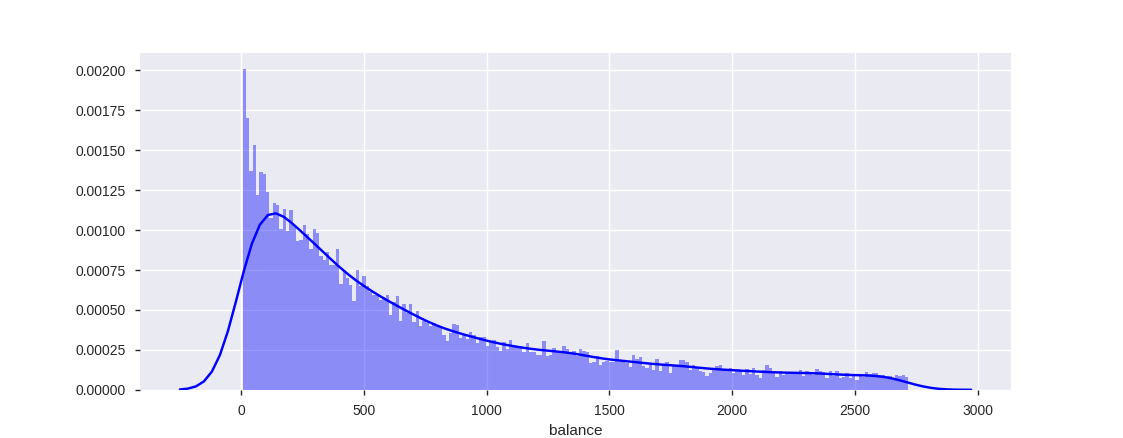

In [466]:
sns.distplot(df3.balance , color="b", label="yes", bins=200)

In [428]:
le = preprocessing.LabelEncoder()
df2.job = le.fit_transform(df2.job)
df2.marital = le.fit_transform(df2.marital)
df2.education = le.fit_transform(df2.education)
df2.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,age,job,marital,education,balance,has_credit,has_credit_bin
0,58,4,1,2,2143,yes,1
1,44,9,2,1,29,yes,1
2,33,2,1,1,2,yes,1
3,47,1,1,3,1506,yes,1
4,33,11,2,3,1,no,0


In [429]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df2[[ 'balance', 'has_credit_bin']])
kmeans.cluster_centers_

array([[8.96424182e+02, 6.26270560e-01],
       [1.18488154e+04, 4.66458658e-01]])

In [431]:
pd.value_counts(kmeans.labels_)

0    43289
1     1922
dtype: int64

In [411]:
df2 = df[['age', 'job', 'marital', 'education', 'balance', 'has_credit']]

In [413]:
df3 = pd.concat([df2.age, df2.balance, pd.get_dummies(df2.job), pd.get_dummies(df2.marital), pd.get_dummies(df2.education)], axis=1)
df3.head()

,age,balance,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,...,technician,unemployed,unknown,divorced,married,single,primary,secondary,tertiary,unknown
0,58,2143,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,44,29,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
2,33,2,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,47,1506,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,33,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [415]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df3)
kmeans.cluster_centers_

array([[4.36918272e+01, 1.18545185e+04, 7.60020822e-02, 1.43154607e-01,
        3.69599167e-02, 2.55075482e-02, 3.12857887e-01, 6.92347736e-02,
        4.78917231e-02, 5.46590318e-02, 1.87402395e-02, 1.64497657e-01,
        4.06038522e-02, 9.89068194e-03, 8.69338886e-02, 6.43935450e-01,
        2.69130661e-01, 1.32743363e-01, 3.86777720e-01, 4.34148881e-01,
        4.63300364e-02],
       [4.08139293e+01, 8.96677108e+02, 1.16077616e-01, 2.18456918e-01,
        3.27096327e-02, 2.75121275e-02, 2.04596905e-01, 4.92261492e-02,
        3.43497343e-02, 9.35319935e-02, 2.08362208e-02, 1.68191268e-01,
        2.82975283e-02, 6.21390621e-03, 1.16424116e-01, 6.00069300e-01,
        2.83506584e-01, 1.52367752e-01, 5.18803419e-01, 2.87987988e-01,
        4.08408408e-02]])

In [416]:
pd.value_counts(kmeans.labels_)

1    43290
0     1921
dtype: int64

#### Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário? 

In [274]:
df.housing.value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [234]:
df[['age', 'job', 'marital', 'education', 'default', 'balance', 'loan', 'housing']].head()

,age,job,marital,education,default,balance,loan,housing
0,58,management,married,tertiary,no,2143,no,yes
1,44,technician,single,secondary,no,29,no,yes
2,33,entrepreneur,married,secondary,no,2,yes,yes
3,47,blue-collar,married,unknown,no,1506,no,yes
4,33,unknown,single,unknown,no,1,no,no


In [251]:
df2 = df[['age', 'job', 'marital', 'education', 'default', 'balance', 'loan', 'housing']]

In [266]:
df2.default = df2.default.apply(lambda x: 0 if x == 'no' else 1)
df2.loan = df2.loan.apply(lambda x: 0 if x == 'no' else 1)
df2.housing = df2.housing.apply(lambda x: 0 if x == 'no' else 1)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [267]:
df3 = pd.concat([df2.housing, df2.loan, df2.age, df2.balance, df2.default, pd.get_dummies(df2.job), pd.get_dummies(df2.marital), pd.get_dummies(df2.education)], axis=1)

In [263]:
df3.columns

Index(['housing', 'loan', 'age', 'balance', 'default', 'admin.', 'blue-collar',
       'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed',
       'services', 'student', 'technician', 'unemployed', 'unknown',
       'divorced', 'married', 'single', 'primary', 'secondary', 'tertiary',
       'unknown'],
      dtype='object')

In [269]:

kmeans = KMeans(n_clusters=2, random_state=0).fit(df3.drop('housing', axis=1))
kmeans.cluster_centers_

array([[1.00000000e+00, 4.36918272e+01, 1.18545185e+04, 1.00000000e+00,
        7.60020822e-02, 1.43154607e-01, 3.69599167e-02, 2.55075482e-02,
        3.12857887e-01, 6.92347736e-02, 4.78917231e-02, 5.46590318e-02,
        1.87402395e-02, 1.64497657e-01, 4.06038522e-02, 9.89068194e-03,
        8.69338886e-02, 6.43935450e-01, 2.69130661e-01, 1.32743363e-01,
        3.86777720e-01, 4.34148881e-01, 4.63300364e-02],
       [1.00000000e+00, 4.08139293e+01, 8.96677108e+02, 1.00000000e+00,
        1.16077616e-01, 2.18456918e-01, 3.27096327e-02, 2.75121275e-02,
        2.04596905e-01, 4.92261492e-02, 3.43497343e-02, 9.35319935e-02,
        2.08362208e-02, 1.68191268e-01, 2.82975283e-02, 6.21390621e-03,
        1.16424116e-01, 6.00069300e-01, 2.83506584e-01, 1.52367752e-01,
        5.18803419e-01, 2.87987988e-01, 4.08408408e-02]])

In [273]:
pd.value_counts(kmeans.labels_)

1    43290
0     1921
dtype: int64

In [276]:
le = preprocessing.LabelEncoder()
le.fit_transform(df2.job)

array([4, 9, 2, ..., 5, 1, 2])

In [278]:
df3 = df2

In [279]:
df3.job = le.fit_transform(df2.job)
df3.marital = le.fit_transform(df2.marital)
df3.education= le.fit_transform(df2.education)
df3.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,age,job,marital,education,default,balance,loan,housing
0,58,4,1,2,1,2143,1,1
1,44,9,2,1,1,29,1,1
2,33,2,1,1,1,2,1,1
3,47,1,1,3,1,1506,1,1
4,33,11,2,3,1,1,1,0


In [306]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df3[['age', 'balance', 'housing']])#.drop(['default', 'loan'], axis=1))
kmeans.cluster_centers_

array([[4.36852237e+01, 1.18516670e+04, 4.45369407e-01],
       [4.08141560e+01, 8.96550579e+02, 5.60742914e-01]])

In [307]:
pd.value_counts(kmeans.labels_)

1    43290
0     1921
dtype: int64

In [308]:
df.housing.value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

<IPython.core.display.Javascript object>


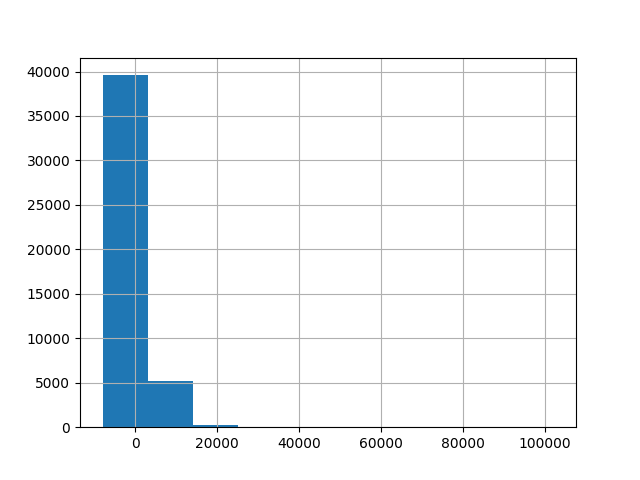

In [305]:
df.balance.hist()